# Team ID: 7
### Project
Learning the graphical structure of electronic health records with graph convolutional transformer
### Member
Chaochao Zhou (cz76@illinois.edu)
### Github Link
https://github.com/zcc861007/EHR-GCT

# Introduction

In this project, we attempt to reconstruct the graph structure of diagnoses and treatments in a single visit, while predicting the readmission based on the learned embedding of the single visit.  Previous studies (e.g., MiME) have demonstrated that incorporating the hierarchical structures in EHR data, such as the relations between diagnosis and treatments, can significantly boost accuracy of prediction tasks, such as heart failure prediction.  However, most publicly available EHR data do not always contain the entire structure information. In particular, when it comes to claims data, such structure information is completely unavailable.  

The major contribution of the original paper is that the authors proposed Graph Convolutional Transformer (GCT), a novel approach to jointly learn the hidden encounter structure while performing various prediction tasks (e.g., readmission) based on single visit recode where the structure information is unavailable.

# Scope of Reproducibility

The paper code was written using Tensorflow 1 and Python 2. In the Draft submission, I have revised the code using Tensorflow 2 and Python 3. In the Final submission, I further write a PyTorch version of the GCT. To my best knowledge, the PyTorch version has not been avaiable publicly (e.g., on GitHub).

There are two aspects that I try to reproduce:

1. The performance metrices (e.g., AUC-ROC and AUC-PR) to predict the readmission in the hold-out datasets.
2. GCT performs better than Transformer (which is an ablated model of the GCT)

# Methodology

## Environment

Python version: 3.10.12.

PyTorch version: 2.2.1

Numpy version: 1.25.2

In [3]:
PROJ_DIR = '/content/drive/My Drive/Courses/CS598-DL4H/project'

## import  packages you need
# import tensorflow as tf
import numpy as np
print(np.__version__)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns

import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import time
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score

# print(os.path.exists(PROJ_DIR))
# sys.path.append(os.path.join(PROJ_DIR, 'tensorflow'))
# from graph_convolutional_transformer import SequenceExampleParser, FeatureEmbedder, create_matrix_vdp

print('Python version:', sys.version)

1.25.2
2.2.1+cu121
Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


## Data

The dataset adopted in this project is eICU Collaborative Research Dataset (https://physionet.org/content/eicu-crd/2.0/) inlcuding the patient, admissionDx, diagnosis, treatment CSV files

Using the paper code, 10 folds were generated. Each fold includes 32820 as training data, 4103 as validation data, 4103 as test data. In particular, this experiment only use fold-0, which has been upload on GitHub (EHR-GCT/eicu_samples/proc_data/fold_0/)

I further wrote a code (EHR-GCT/pytorch/data-proc-pytorch.ipynb) to generate Pytorch tensors datasets from the fold-0 Tensorflow datasets. In particular, the training data includes 15000 samples, and the hold-out (valid) dataset includes 1000 samples.

**In short, to run the PyTorch version model, please first run EHR-GCT/pytorch/data-proc-pytorch.ipynb, and then upload all tensors using the code below**

In [2]:
train_dir = os.path.join(PROJ_DIR, 'pytorch/train')
valid_dir = os.path.join(PROJ_DIR, 'pytorch/valid')

train_embeddings = torch.load(os.path.join(train_dir, 'embeddings.pt'))
train_masks = torch.load(os.path.join(train_dir, 'masks.pt'))
train_guide = torch.load(os.path.join(train_dir, 'guide.pt'))
train_prior = torch.load(os.path.join(train_dir, 'prior.pt'))
train_labels = torch.load(os.path.join(train_dir, 'labels.pt'))

valid_embeddings = torch.load(os.path.join(valid_dir, 'embeddings.pt'))
valid_masks = torch.load(os.path.join(valid_dir, 'masks.pt'))
valid_guide = torch.load(os.path.join(valid_dir, 'guide.pt'))
valid_prior = torch.load(os.path.join(valid_dir, 'prior.pt'))
valid_labels = torch.load(os.path.join(valid_dir, 'labels.pt'))

print(train_embeddings.shape)
print(train_masks.shape)
print(train_guide.shape)
print(train_prior.shape)
print(train_labels.shape)

print(valid_embeddings.shape)
print(valid_masks.shape)
print(valid_guide.shape)
print(valid_prior.shape)
print(valid_labels.shape)

torch.Size([15000, 101, 128])
torch.Size([15000, 101])
torch.Size([15000, 101, 101])
torch.Size([15000, 101, 101])
torch.Size([15000])
torch.Size([1000, 101, 128])
torch.Size([1000, 101])
torch.Size([1000, 101, 101])
torch.Size([1000, 101, 101])
torch.Size([1000])


In [3]:
class CustomDataset(Dataset):
    def __init__(self, embeddings, masks, guide, prior, labels):
        self.embeddings = embeddings
        self.masks = masks
        self.guide = guide
        self.prior = prior
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx],
            'masks': self.masks[idx],
            'guide': self.guide[idx],
            'prior': self.prior[idx],
            'labels': self.labels[idx]
        }


def create_data_loader(embeddings, masks, guide, prior, labels, batch_size=32):
    dataset = CustomDataset(embeddings, masks, guide, prior, labels)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader

In [4]:
train_data_loader = create_data_loader(train_embeddings, train_masks, train_guide, train_prior, train_labels, batch_size=32)
valid_data_loader = create_data_loader(valid_embeddings, valid_masks, valid_guide, valid_prior, valid_labels, batch_size=1000)

In [5]:
batch_nums = 0
for _ in train_data_loader:
  batch_nums += 1
print(batch_nums)

469


In [6]:
## Load a sample for model testing
data_iterator = iter(train_data_loader)
batch = next(data_iterator)

embeddings = batch['embeddings']
masks = batch['masks']
guide = batch['guide']
prior = batch['prior']
labels = batch['labels']

print(embeddings.shape)
print(masks.shape)
print(guide.shape)
print(prior.shape)
print(labels.shape)

torch.Size([32, 101, 128])
torch.Size([32, 101])
torch.Size([32, 101, 101])
torch.Size([32, 101, 101])
torch.Size([32])


## Model

**Citation to the original paper**: Choi, Edward, et al, Learning the graphical structure of electronic health records with graph convolutional transformer, Proceedings of the AAAI conference on artificial intelligence, 2020, 34:1, doi: https://doi.org/10.48550/arXiv.1906.04716

**Like to the original paper's repo**: https://github.com/Google-Health/records-research/tree/master/graph-convolutional-transformer

**Model descriptions**:

The GCT consists of three layers of multi-headed transformers. As shown in Eq. (3) below, the attention mechanism in the first GCT block is replaced with the conditional probabilities P. The following blocks use the masked self-attention mechanism. Based on the GCT, an EHRModel as the final layer is used to predict the readmission according to the diagnosis and treatments in a single visit.


<img src="https://drive.google.com/uc?id=1tI-Ldh4rT8iAsIZcg34wi9EmBU48x307" width="500" height="350" alt="Model Architecture">


Except a BCE loss with respect to the readmission labels, a regularization term is further introduced for the training of the GCT.  GCT is expected to gradually improve upon P, instead of drastically deviating from the informative P. Based on the fact that attention is itself a probability distribution, we sequentially penalize attention of j-th block if it deviates too much from the attention of (j – 1)-th block, using KL divergence. As shown by Eq. (4), the regularization terms are summed to the prediction loss term (e.g. negative log-likelihood), and the trade-off is controlled by the coefficient λ.

In my code, the `guide` tensor of each sample is a 0/1 mask, representing permissible connections in the eICU encounter record (e.g., diagnosis codes can only be linked with procedure codes, not with themselves). Movermore, the `prior` tensor of each sample denotes conditional probabilities of these permissible connections, which can be computed by going through the training data, and counting the number of occurrences of each code and the co-occurrence of code pairs.

In [7]:
class Attention(nn.Module):
    def forward(self, query, key, value, mask=None, dropout=None):
        d_k = query.size(-1)  # Dimension of the key, used for scaling down the dot product
        # Calculate the dot products of the query with all keys, divide each by sqrt(d_k),
        # and apply a softmax to obtain the weights on the values
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Apply mask - set scores to -inf where mask is 0 to ignore these positions
            # scores = scores.masked_fill(mask == 0, -1e9)
            scores = scores.masked_fill(mask == 0, float('-inf'))
        p_attn = torch.softmax(scores, dim=-1)  # Softmax to obtain the weights
        p_attn = p_attn.masked_fill(torch.isnan(p_attn), 0)  # Replace any NaNs with zero
        if dropout is not None:
            p_attn = dropout(p_attn)  # Apply dropout to the attention weights
        # Multiply the weights by the value to get the output
        return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0  # Ensure that d_model is divisible by h
        self.d_k = d_model // h  # Dimension of each head
        self.h = h  # Number of heads
        # Linear layers for projecting Q, K, V
        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model, bias=False) for _ in range(3)])
        self.attention = Attention()  # The attention mechanism defined above
        self.dropout = nn.Dropout(p=dropout)
        self.output_linear = nn.Linear(d_model, d_model, bias=False)  # Final projection

    def forward(self, query, key, value, mask=None, training=False):
        batch_size = query.size(0)
        # Prepare Q, K, V for multi-head processing (split into h heads)
        query, key, value = \
            [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linear_layers, (query, key, value))]
        if mask is not None:
            mask = mask.unsqueeze(1)  # Adjust mask for multi-heads
        if training:
            x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)
        else:
            x, attn = self.attention(query, key, value, mask=mask)
        # Concatenate heads and apply final linear projection
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)
        x = self.output_linear(x)  # Apply final linear projection
        return x, attn


class PositionwiseFeedForward(nn.Module):
    def __init__(self, embedding_size, num_feedforward, dropout=0.1):
        super().__init__()
        self.num_feedforward = num_feedforward
        self.ff_layers = nn.ModuleList([nn.Linear(embedding_size, embedding_size) for _ in range(num_feedforward)])
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, training):
        # for layer in self.ff_layers:
        #     x = F.relu(layer(x))
        #     if training:
        #         x = self.dropout(x)
        for i in range(self.num_feedforward):
            if i < self.num_feedforward - 1:
                x = F.relu(self.ff_layers[i](x))
            else:
                x = self.ff_layers[i](x)
            if training:
                x = self.dropout(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, embedding_size, num_attention_heads, num_feedforward):
        super(TransformerBlock, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.multihead_attention = MultiHeadedAttention(num_attention_heads, embedding_size, dropout=0.1)
        self.feed_forward = PositionwiseFeedForward(embedding_size, num_feedforward, dropout=0.1)
        self.layer_norm1 = nn.LayerNorm(embedding_size)
        self.layer_norm2 = nn.LayerNorm(embedding_size)

    def forward(self, features, masks=None, prior=None, training=False):
        # Apply multi-head attention
        if masks is not None and prior is None:
            attn_output, attention = self.multihead_attention(features, features, features, masks, training)
        elif masks is None and prior is not None:
            # attn_output = torch.matmul(prior, features)
            attention = prior.unsqueeze(1).repeat(1, self.num_attention_heads, 1, 1)  # (batches, heads, seq_len, seq_len)

            batch_size = features.size(0)
            h = self.multihead_attention.h
            d_k = self.multihead_attention.d_k

            value = self.multihead_attention.linear_layers[-1](features)
            value = value.view(batch_size, -1, h, d_k).transpose(1, 2)
            attn_output = torch.matmul(attention, value)
            attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, h * d_k)
            attn_output = self.multihead_attention.output_linear(attn_output)

        # Apply residual connection and layer normalization
        features = self.layer_norm1(features + attn_output)

        # Apply feedforward network
        ffn_output = self.feed_forward(features, training)

        # Apply second residual connection and layer normalization
        features = self.layer_norm2(features + ffn_output)

        return features, attention

In [8]:
# model = PositionwiseFeedForward(embedding_size=128, num_feedforward=1, dropout=0.1)
# hidden = model(embeddings, training=True)
# print(hidden.shape)

# print(embeddings.shape)
# print(masks.shape)
# model = MultiHeadedAttention(h=4, d_model=128, dropout=0.1)
# hidden, attention = model(embeddings, embeddings, embeddings)
# print(hidden.shape)
# print(attention.shape)

In [9]:
# model = TransformerBlock(embedding_size=128, num_attention_heads=1, num_feedforward=2)
# # hidden, attensions = model(embeddings, torch.einsum("ab,ac->abc", masks, masks), training=False)
# hidden, attensions = model(embeddings, prior=prior, training=False)
# print(hidden.shape)
# print(attensions.shape)

# attensions[0,0]
# print(masks[0])
# print(hidden[0])

In [10]:
class GCT(nn.Module):
    def __init__(self,
                 embedding_size=128,
                 num_transformer_stack=3,
                 num_feedforward=2,
                 num_attention_heads=1,
                 directed_attention=False,
                 use_guide=True,
                 use_prior=True):

        super(GCT, self).__init__()

        self.hidden_size = embedding_size
        self.num_stack = num_transformer_stack
        self.num_feedforward = num_feedforward
        self.num_heads = num_attention_heads
        self.use_guide = use_guide
        self.use_prior = use_prior
        self.directed_attention = directed_attention

        # Define transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embedding_size, num_attention_heads, num_feedforward)
            for _ in range(num_transformer_stack)
        ])

    def forward(self, features, masks, guide=None, prior=None, training=None):
        batch_size = features.size(0)
        num_codes = masks.size(1)

        combined_masks = attn_masks = torch.einsum("ab,ac->abc", masks, masks)

        if self.use_prior:
            prior = attn_masks * prior

        if self.directed_attention:
            directed_masks = torch.triu(torch.ones(num_codes, num_codes), diagonal=0).unsqueeze(0)
            combined_masks = combined_masks * directed_masks

        if self.use_guide:
            combined_masks = combined_masks * guide

        attentions = []
        for i, transformer_block in enumerate(self.transformer_blocks):
            features = features * masks[..., None]
            # features.masked_fill(masks[..., None] == 0, 0)

            if self.use_prior and i == 0:
                features, attention = transformer_block(features, masks=None, prior=prior, training=training)
            else:
                features, attention = transformer_block(features, masks=combined_masks, prior=None, training=training)

            attentions.append(attention)

        return features * masks[..., None], attentions
        # return features.masked_fill(masks[..., None] == 0, 0), attentions

In [11]:
# model = GCT(num_transformer_stack=3, use_guide=False, use_prior=False)

# hidden, attensions = model(embeddings, masks, guide, prior, training=True)
# print(hidden.shape)
# print([attn.shape for attn in attensions])

# print(masks[0])
# print(hidden[0])
# print(attensions[0][0])
# print(prior[0])
# print(guide[0])

In [12]:
class EHRModel(nn.Module):
  def __init__(self, gct_params, num_classes=1):
    super(EHRModel, self).__init__()
    self.gct = GCT(**gct_params)
    # self.linear = nn.Linear(gct_params['embedding_size'], gct_params['embedding_size']//2)
    # self.classifier = nn.Linear(gct_params['embedding_size']//2, num_classes)
    self.classifier = nn.Linear(gct_params['embedding_size'], num_classes)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x, masks, guide=None, prior=None, training=None):
    hidden, attentions = self.gct(x, masks, guide, prior, training)

    # hidden = hidden[:, 0, :]  # paper code doesn't make sense
    # hidden = hidden.mean(dim=1)
    hidden = hidden.sum(dim=1)

    ## mean pooling
    # hidden = hidden.sum(dim=1) / masks.sum(dim=-1, keepdim=True)

    ## max pooling
    # masks_expanded = masks.unsqueeze(-1).type_as(hidden)  # Shape [batch, seq_len, 1]
    # hidden_masked = hidden * masks_expanded + (1.0 - masks_expanded) * hidden.min()
    # hidden, _ = torch.max(hidden_masked, dim=1)

    if training: hidden = self.dropout(hidden)
    # hidden = F.relu(self.linear(hidden))
    # if training: hidden = self.dropout(hidden)
    logits = self.classifier(hidden)
    logits = logits.squeeze(-1)
    return logits, attentions

In [13]:
criterion = nn.BCEWithLogitsLoss()

def get_loss(labels, logits, attentions=None, reg_coef=0, use_prior=False, is_print=False):
  loss = criterion(logits, labels)
  if is_print: print('loss:', loss)

  if use_prior and len(attentions) > 1:
    kl_terms = []
    attention_tensor = torch.stack(attentions)  # shape: (stacks, batches, heads, seq_len, seq_len)
    if is_print: print(attention_tensor.shape)
    for i in range(1, len(attention_tensor)):  # i is stack
      log_p = torch.log(attention_tensor[i - 1] + 1e-12)
      log_q = torch.log(attention_tensor[i] + 1e-12)
      kl_term = attention_tensor[i - 1] * (log_p - log_q)
      kl_term = torch.sum(kl_term, dim=-1)
      kl_term = torch.mean(kl_term)
      kl_terms.append(kl_term)

    kl_terms = torch.stack(kl_terms)
    if is_print: print(kl_terms)
    reg_term = torch.mean(kl_terms)
    if is_print: print('reg:', reg_coef * reg_term)
    loss += reg_coef * reg_term

  return loss

## Training

**Hyperparameters**:

In this project, I didn't perform hyperparameter tuning. Instead, we directly use the tuned hyperparameters reported in the original paper. Concretely, Learning rate = 0.00022, Transformer droupout rate = 0.1, Regulation coeficient = 0.1.

**Computational requirement**

One T4 GPU on Google Colab. 30 epochs (each epoch includes 15000 samples in the training dataset) were performed, with ~ 6 sec/epoch. In total, each training took ~ 3 min.  

In [14]:
def train_model(model, gct_params, data_loader, saving_path, n_epoch=5, lr=0.00022, device=None):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Ensure model is on the correct device
    model.train()

    tic = time.time()
    loss_history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for batch in data_loader:
            embeddings, masks, guide, prior, labels = batch['embeddings'], batch['masks'], batch['guide'], batch['prior'], batch['labels']
            embeddings, masks, guide, prior, labels = embeddings.to(device), masks.to(device), guide.to(device), prior.to(device), labels.to(device)

            optimizer.zero_grad()
            if gct_params['use_prior']:
                logits, attentions = model(embeddings, masks, guide, prior, training=True)
                loss = get_loss(labels, logits, attentions, reg_coef=0.1, use_prior=True)
            else:
                logits, attentions = model(embeddings, masks, training=True)
                loss = get_loss(labels, logits)
            loss.backward()
            optimizer.step()
            curr_epoch_loss.append(loss.item())  # Change from cpu().data.numpy() to item()

        epoch_loss = np.mean(curr_epoch_loss)
        loss_history.append(epoch_loss)

        if epoch == 0:
            best_loss = epoch_loss

        print(f"Epoch {str(epoch+1).zfill(2)}: Current Epoch Loss = {epoch_loss} | Model Saving = {epoch_loss < best_loss}")

        if epoch_loss < best_loss:
            torch.save(model.state_dict(), saving_path)
            best_loss = epoch_loss

    toc = time.time()
    print(f"Training time: {(toc - tic)/60} min")
    return model, loss_history

## Evaluation

The performance metrics to predict readmission include AUC-ROC, AUC-PR, and F1 scores of both the training and hold-out datasets.

In [30]:
def eval_model(model, gct_params, data_loader, device=None):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Ensure model is on the correct device
    Y_pred = []
    Y_test = []
    Attens = []
    for batch in data_loader:
        embeddings, masks, guide, prior, labels = batch['embeddings'], batch['masks'], batch['guide'], batch['prior'], batch['labels']
        embeddings, masks, guide, prior, labels = embeddings.to(device), masks.to(device), guide.to(device), prior.to(device), labels.to(device)

        if gct_params['use_prior']:
            logits, attentions = model(embeddings, masks, guide, prior, training=False)
        else:
            logits, attentions = model(embeddings, masks, training=False)

        probs = torch.sigmoid(logits)

        Y_pred.append(probs.cpu().data.numpy())
        Y_test.append(labels.cpu().data.numpy())
        attentions = torch.stack(attentions)
        Attens.append(attentions.cpu().data.numpy())

    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)
    Attens = np.concatenate(Attens, axis=1)
    Attens = np.swapaxes(Attens, 0, 1)  # (batches, stacks, heads, seq_len, seq_len)

    return Y_pred, Y_test, Attens

In [31]:
def evaluate_predictions(pred, truth):
    """
    TODO: Evaluate the performance of the predictoin via AUROC, and F1 score
    each prediction in pred is a vector representing [p_0, p_1].
    When defining the scores we are interesed in detecting class 1 only
    (Hint: use roc_auc_score and f1_score from sklearn.metrics, be sure to read their documentation)
    return: auc_roc, auc_pr, f1
    """

    auc_roc = roc_auc_score(truth, pred)

    precision, recall, _ = precision_recall_curve(truth, pred)
    auc_pr = auc(recall, precision)

    y_pred = (pred>0.5).astype(int)
    f1 = f1_score(truth, y_pred)

    return auc_roc, auc_pr, f1

In [32]:
def plot_attentions(attentions, sample_idx=0):
  plt.figure(figsize=(12, 3))  # You can adjust the size as needed

  plt.subplot(1,3,1)
  sns.heatmap((attentions[sample_idx][0,0,:,:]*255).astype('int64'),
              annot=False, fmt='d', cmap='Blues', cbar=True)
  plt.title('Layer 1')

  plt.subplot(1,3,2)
  sns.heatmap((attentions[sample_idx][1,0,:,:]*255).astype('int64'),
              annot=False, fmt='d', cmap='Blues', cbar=True)
  plt.title('Layer 2')

  plt.subplot(1,3,3)
  sns.heatmap((attentions[sample_idx][2,0,:,:]*255).astype('int64'),
              annot=False, fmt='d', cmap='Blues', cbar=True)
  plt.title('Layer 3')

  plt.show()

# Restuls

In this work, I developed two models, including:

1. GCT model (full model): consiting of three layers of transformer blocks, where the attention scores in the first block were fed with the conditional probabilities.

2. Transformer model (ablated model): consisting of three layers of transformer blocks.

**Hypotheses**:

Hypothesis 1: GCT can rescontruct the graph structure in a single visit. To test it, we will plot the graph structure, represtned by the confusion matrix of the attention scores.

Hypothesis 2: Prediction performance can be improved by introducing prior condictional probabilities, based on the fact that some connections are not allowed in the encounter record (e.g., dignosis codes can only connect to treatments, instead of themselves). Correspondingly, it is expected that the GCT model with prior could perform better than the transformer model.

## Full Model Experiement - GCT Model

In [33]:
gct_params = {
    "embedding_size": 128,
    "num_transformer_stack": 3,
    "num_feedforward": 2,
    "num_attention_heads": 1,
    "directed_attention": False,
    "use_guide": True,  # Use guide mask
    "use_prior": True,  # Use conditional probability
}

model = EHRModel(gct_params)

logits, attentions = model(embeddings, masks, guide, prior, training=False)
print(get_loss(labels, logits, attentions, reg_coef=0.1, use_prior=gct_params['use_prior']))
print(logits)
print(labels)

tensor(1.9267, grad_fn=<AddBackward0>)
tensor([ 7.2145,  3.1077, -0.2710,  1.0725,  2.5179, -0.0640, -1.7395,  0.7120,
        -0.4769,  1.9014,  1.4724,  1.4009,  2.1358,  2.1549,  1.1592,  1.0248,
        -0.2226,  0.7097, -1.2805,  3.3826,  1.5088,  3.6150,  2.6214,  3.2371,
        -0.5430,  0.4157,  1.8414,  4.6911,  2.3802,  5.3201,  5.9477,  0.6633],
       grad_fn=<SqueezeBackward1>)
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [34]:
## Check if batches are unique

# preds = []

# for batch in train_data_loader:
#   embeddings, masks, guide, prior, labels = batch['embeddings'], batch['masks'], batch['guide'], batch['prior'], batch['labels']
#   logits, attentions = model(embeddings, masks, guide, prior, training=False)
#   preds.append(logits.cpu().data.numpy())

# print(len(preds))

# # Dictionary to track unique arrays
# unique_arrays = {}

# # Check for duplicates
# for idx, arr in enumerate(preds):
#     # Convert array to a tuple of its data and use as a key
#     array_key = tuple(arr.tolist())
#     if array_key in unique_arrays:
#         print(f"Duplicate array found: {arr} at indices {unique_arrays[array_key]} and {idx}")
#     else:
#         unique_arrays[array_key] = idx

# print(len(unique_arrays))

In [35]:
model_path = os.path.join(PROJ_DIR, 'pytorch/gct-model.pth')
TRAIN_MODEL = not os.path.exists(model_path)
# TRAIN_MODEL = False

if TRAIN_MODEL:
  model, loss_history = train_model(model, gct_params, train_data_loader, saving_path=model_path, n_epoch=30)
else:
  model.load_state_dict(torch.load(model_path))
  print('Model loaded.')

Model loaded.


```
Epoch 01: Current Epoch Loss = 0.5718378442436901 | Model Saving = False
Epoch 02: Current Epoch Loss = 0.49807304553767 | Model Saving = True
Epoch 03: Current Epoch Loss = 0.4781472231469937 | Model Saving = True
Epoch 04: Current Epoch Loss = 0.46123988449827696 | Model Saving = True
Epoch 05: Current Epoch Loss = 0.44686552688384107 | Model Saving = True
Epoch 06: Current Epoch Loss = 0.43478345708933464 | Model Saving = True
Epoch 07: Current Epoch Loss = 0.4236524905731429 | Model Saving = True
Epoch 08: Current Epoch Loss = 0.407588240275505 | Model Saving = True
Epoch 09: Current Epoch Loss = 0.3903668244510317 | Model Saving = True
Epoch 10: Current Epoch Loss = 0.37955509523338854 | Model Saving = True
Epoch 11: Current Epoch Loss = 0.3595999511701466 | Model Saving = True
Epoch 12: Current Epoch Loss = 0.34058682337752794 | Model Saving = True
Epoch 13: Current Epoch Loss = 0.3229452586059631 | Model Saving = True
Epoch 14: Current Epoch Loss = 0.3014497362029578 | Model Saving = True
Epoch 15: Current Epoch Loss = 0.2919875438978423 | Model Saving = True
Epoch 16: Current Epoch Loss = 0.27509326703830567 | Model Saving = True
Epoch 17: Current Epoch Loss = 0.2592397846583364 | Model Saving = True
Epoch 18: Current Epoch Loss = 0.2507805527845171 | Model Saving = True
Epoch 19: Current Epoch Loss = 0.24475414850818578 | Model Saving = True
Epoch 20: Current Epoch Loss = 0.24092261169129597 | Model Saving = True
Epoch 21: Current Epoch Loss = 0.22628370643869392 | Model Saving = True
Epoch 22: Current Epoch Loss = 0.21841317275439753 | Model Saving = True
Epoch 23: Current Epoch Loss = 0.21938536216073962 | Model Saving = False
Epoch 24: Current Epoch Loss = 0.20489505019142176 | Model Saving = True
Epoch 25: Current Epoch Loss = 0.20742542581009205 | Model Saving = False
Epoch 26: Current Epoch Loss = 0.20225612800131473 | Model Saving = True
Epoch 27: Current Epoch Loss = 0.19734561468746617 | Model Saving = True
Epoch 28: Current Epoch Loss = 0.19191358409234202 | Model Saving = True
Epoch 29: Current Epoch Loss = 0.1878924439710849 | Model Saving = True
Epoch 30: Current Epoch Loss = 0.18411940366411006 | Model Saving = True
Training time: 2.9506580034891763 min
```

In [36]:
## Check loss function

# model.to('cpu')
# logits, attentions = model(embeddings, masks, guide, prior, training=False)
# print(get_loss(labels, logits, attentions, reg_coef=0.1, use_prior=gct_params['use_prior'], is_print=True))
# print(torch.sigmoid(logits).detach().numpy())
# print(labels)

In [37]:
print('Evaluvate training dataset:\n')

Y_pred, Y_test, _ = eval_model(model, gct_params, train_data_loader)
print('Percentage of positive labels in training dataset:', (Y_test == 1).sum() / len(Y_test) * 100, '%')

print(Y_pred.shape, Y_test.shape)
print('Probs', 'Labels')
print(np.stack((Y_pred, Y_test), axis=-1)[:30])

auc_roc, auc_pr, f1 = evaluate_predictions(Y_pred, Y_test)
print(f'AUROC: {auc_roc}, AUPR: {auc_pr}, F1: {f1}')

Evaluvate training dataset:

Percentage of positive labels in training dataset: 16.86 %
(15000,) (15000,)
Probs Labels
[[0.163 0.000]
 [0.000 0.000]
 [0.009 0.000]
 [0.031 0.000]
 [0.000 0.000]
 [0.987 1.000]
 [0.002 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.006 0.000]
 [0.002 0.000]
 [0.032 0.000]
 [0.041 0.000]
 [0.015 0.000]
 [0.168 0.000]
 [0.031 0.000]
 [1.000 1.000]
 [0.002 0.000]
 [0.039 0.000]
 [0.004 0.000]
 [0.000 0.000]
 [1.000 1.000]
 [0.000 0.000]
 [0.002 0.000]
 [0.006 0.000]
 [0.000 0.000]
 [0.378 1.000]
 [0.000 0.000]
 [0.213 0.000]]
AUROC: 0.9933655174508617, AUPR: 0.9727438246830912, F1: 0.9095305258915979


In [38]:
print('Evaluvate valid dataset:\n')

Y_pred, Y_test, Attens = eval_model(model, gct_params, valid_data_loader)
print('Percentage of positive labels in valid dataset:', (Y_test == 1).sum() / len(Y_test) * 100, '%')

print(Y_pred.shape, Y_test.shape)
print('Probs', 'Labels')
print(np.stack((Y_pred, Y_test), axis=-1)[:30])

auc_roc, auc_pr, f1 = evaluate_predictions(Y_pred, Y_test)
print(f'AUROC: {auc_roc}, AUPR: {auc_pr}, F1: {f1}')

Evaluvate valid dataset:

Percentage of positive labels in valid dataset: 17.0 %
(1000,) (1000,)
Probs Labels
[[0.128 1.000]
 [0.056 0.000]
 [0.071 0.000]
 [0.941 1.000]
 [0.996 0.000]
 [0.250 0.000]
 [0.983 0.000]
 [0.994 0.000]
 [0.607 1.000]
 [0.898 0.000]
 [0.999 0.000]
 [0.013 1.000]
 [0.000 0.000]
 [0.303 0.000]
 [1.000 0.000]
 [0.093 0.000]
 [0.009 0.000]
 [0.046 0.000]
 [0.906 0.000]
 [0.623 0.000]
 [0.986 0.000]
 [0.514 0.000]
 [0.039 0.000]
 [0.845 1.000]
 [0.023 0.000]
 [0.970 1.000]
 [0.271 0.000]
 [0.174 0.000]
 [0.990 0.000]
 [0.002 0.000]]
AUROC: 0.48642806520198445, AUPR: 0.16212240447579085, F1: 0.22809917355371906


963


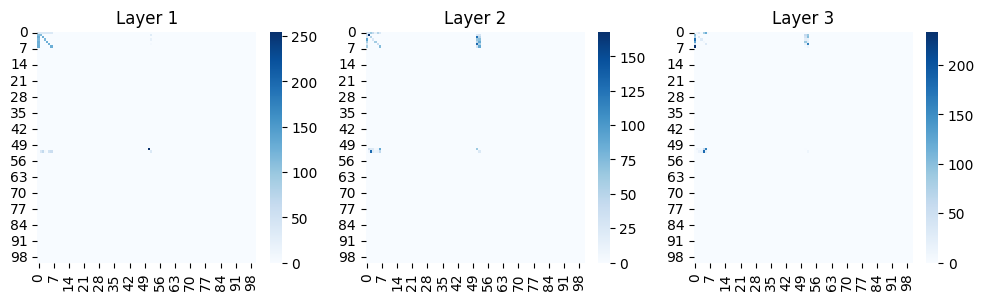

In [39]:
sample_idx = np.random.randint(0, Attens.shape[0])
print(sample_idx)

plot_attentions(Attens, sample_idx)

## Ablation Experiment - Transformer Model

In [40]:
gct_params = {
    "embedding_size": 128,
    "num_transformer_stack": 3,
    "num_feedforward": 2,
    "num_attention_heads": 1,
    "directed_attention": False,
    "use_guide": False,  # Use guide mask
    "use_prior": False,  # Use conditional probability
}

model = EHRModel(gct_params)

logits, attentions = model(embeddings, masks, guide=None, prior=None, training=False)
print(get_loss(labels, logits, attentions, reg_coef=0.1, use_prior=gct_params['use_prior']))
print(logits)
print(labels)

tensor(2.9080, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor([ 3.9092,  2.0680,  2.5308,  4.2400,  1.9131,  0.8485,  8.6475,  2.2304,
         2.4599,  2.3734,  1.6191,  0.1743,  0.8152,  1.3327,  4.8678,  1.8214,
         5.0382,  2.6492, -0.0654,  4.9548, -2.2179,  2.8521,  2.8925,  0.3488,
         1.2165,  3.0145,  7.5845,  3.9650,  2.2559,  3.8811,  7.5332,  0.8816],
       grad_fn=<SqueezeBackward1>)
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [41]:
model_path = os.path.join(PROJ_DIR, 'pytorch/transformer-model.pth')
TRAIN_MODEL = not os.path.exists(model_path)
# TRAIN_MODEL = False

if TRAIN_MODEL:
  model, loss_history = train_model(model, gct_params, train_data_loader, saving_path=model_path, n_epoch=30)
else:
  model.load_state_dict(torch.load(model_path))
  print('Model loaded.')

Model loaded.


```
Epoch 01: Current Epoch Loss = 0.5321193779709497 | Model Saving = False
Epoch 02: Current Epoch Loss = 0.4652942343434291 | Model Saving = True
Epoch 03: Current Epoch Loss = 0.43973866851726323 | Model Saving = True
Epoch 04: Current Epoch Loss = 0.4247698040246201 | Model Saving = True
Epoch 05: Current Epoch Loss = 0.41014998048734563 | Model Saving = True
Epoch 06: Current Epoch Loss = 0.3925960907486202 | Model Saving = True
Epoch 07: Current Epoch Loss = 0.3792679851878681 | Model Saving = True
Epoch 08: Current Epoch Loss = 0.3625848853766029 | Model Saving = True
Epoch 09: Current Epoch Loss = 0.3415393904486953 | Model Saving = True
Epoch 10: Current Epoch Loss = 0.32288252185783917 | Model Saving = True
Epoch 11: Current Epoch Loss = 0.3056293158515938 | Model Saving = True
Epoch 12: Current Epoch Loss = 0.2817051833721875 | Model Saving = True
Epoch 13: Current Epoch Loss = 0.2614868695198346 | Model Saving = True
Epoch 14: Current Epoch Loss = 0.24506763051122998 | Model Saving = True
Epoch 15: Current Epoch Loss = 0.22728869516744035 | Model Saving = True
Epoch 16: Current Epoch Loss = 0.20402611234485468 | Model Saving = True
Epoch 17: Current Epoch Loss = 0.20041184590410577 | Model Saving = True
Epoch 18: Current Epoch Loss = 0.18310483892573348 | Model Saving = True
Epoch 19: Current Epoch Loss = 0.17332585138489187 | Model Saving = True
Epoch 20: Current Epoch Loss = 0.16459224239658954 | Model Saving = True
Epoch 21: Current Epoch Loss = 0.15878937174595875 | Model Saving = True
Epoch 22: Current Epoch Loss = 0.1466944219826508 | Model Saving = True
Epoch 23: Current Epoch Loss = 0.13877841358833604 | Model Saving = True
Epoch 24: Current Epoch Loss = 0.1333205598527625 | Model Saving = True
Epoch 25: Current Epoch Loss = 0.1239477217173589 | Model Saving = True
Epoch 26: Current Epoch Loss = 0.12780700053280986 | Model Saving = False
Epoch 27: Current Epoch Loss = 0.11823994086892493 | Model Saving = True
Epoch 28: Current Epoch Loss = 0.12398828532514987 | Model Saving = False
Epoch 29: Current Epoch Loss = 0.11527246006452707 | Model Saving = True
Epoch 30: Current Epoch Loss = 0.11358764953315575 | Model Saving = True
Training time: 2.7726437290509542 min
```

In [42]:
print('Evaluvate training dataset:\n')

Y_pred, Y_test, _ = eval_model(model, gct_params, train_data_loader)
print('Percentage of positive labels in training dataset:', (Y_test == 1).sum() / len(Y_test) * 100, '%')

print(Y_pred.shape, Y_test.shape)
print('Probs', 'Labels')
print(np.stack((Y_pred, Y_test), axis=-1)[:30])

auc_roc, auc_pr, f1 = evaluate_predictions(Y_pred, Y_test)
print(f'AUROC: {auc_roc}, AUPR: {auc_pr}, F1: {f1}')

Evaluvate training dataset:

Percentage of positive labels in training dataset: 16.86 %
(15000,) (15000,)
Probs Labels
[[0.000 0.000]
 [0.010 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.956 1.000]
 [0.028 0.000]
 [0.001 0.000]
 [0.169 1.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.980 1.000]
 [0.001 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.001 0.000]
 [0.001 0.000]
 [0.025 0.000]
 [0.000 0.000]
 [0.002 0.000]
 [0.000 0.000]
 [0.947 1.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]]
AUROC: 0.9957363638009499, AUPR: 0.9822001547307834, F1: 0.9289867109634552


In [43]:
print('Evaluvate valid dataset:\n')

Y_pred, Y_test, Attens = eval_model(model, gct_params, valid_data_loader)
print('Percentage of positive labels in valid dataset:', (Y_test == 1).sum() / len(Y_test) * 100, '%')

print(Y_pred.shape, Y_test.shape)
print('Probs', 'Labels')
print(np.stack((Y_pred, Y_test), axis=-1)[:30])

auc_roc, auc_pr, f1 = evaluate_predictions(Y_pred, Y_test)
print(f'AUROC: {auc_roc}, AUPR: {auc_pr}, F1: {f1}')

Evaluvate valid dataset:

Percentage of positive labels in valid dataset: 17.0 %
(1000,) (1000,)
Probs Labels
[[0.333 0.000]
 [0.000 0.000]
 [0.146 0.000]
 [0.002 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.001 0.000]
 [0.000 0.000]
 [0.017 0.000]
 [0.000 1.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.260 1.000]
 [0.001 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.155 0.000]
 [0.009 0.000]
 [0.000 0.000]
 [0.653 0.000]
 [0.012 0.000]
 [0.000 0.000]
 [0.003 0.000]
 [0.000 0.000]
 [0.199 0.000]
 [0.011 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.043 1.000]]
AUROC: 0.5718284904323174, AUPR: 0.20706832080260237, F1: 0.16606498194945848


963


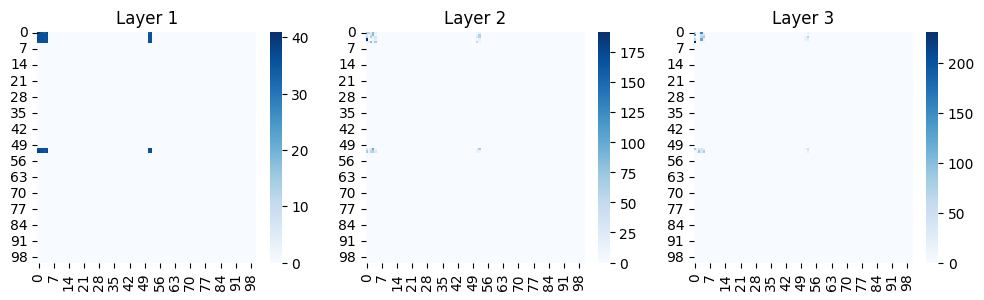

In [44]:
# sample_idx = np.random.randint(0, Attens.shape[0])
print(sample_idx)

plot_attentions(Attens, sample_idx)

## Summary of Results

**In terms of Hypothesis 1**:

In terms of attention score patterns (i.e., graph structure), we can observe that attention only occur outside of the padding locations. In particular, the patterns of layer 2 and layer 3 in the GCT model match the prior, which is the layer 1 pattern.

**In terms of Hypothesis 2**:

The performance metrics of the GCT and Transformer Models using the hold-out dataset are listed beblow:

<img src="https://drive.google.com/uc?id=1HMxH9xTV51EkWQ2hsdoF5XEz7xpikFxJ" width="700" height="200" alt="Model Architecture">

For both models, my reproducing results were inferiror to those reported in the original paper. In particular, my results do not show that the GCT model can outperform the Transformer model.

# Discussion

## Reproducibility

The original code was developed using Tensorflow 1 and Python 2. In this project, I deveoped two versions of the GCT model using Tensorflow 2 and PyTorch through careful coding and debugging. For both the Tensorflow 2 or PyTorch versions, the learning curves behave pretty well (i.e., the losses during training decreased monotonically), and the magitude of training losses in both versions is similar. However, I cannot reproduce the performance metrics (AUC-ROC and AUC-PR) using the hold-out dataset.   

The potential factors causing the irreproducible results include:

1. The preprocessing code for eICU database was written using Python 2. When transferring it to Python 3, I may introduce coding bugs, causing the incorrect training and hold-out datasets.

2. The authors may not provide the newest code in their repo, as I have noticed some bugs. For example, in the provided code, when the embeddings `hidden`, with a shape (`batches, seq_len, embeddings`) from the GCT output are fed to the final classification layer, the authors simply adopted `hidden[:, 0, :]`. I think that this does not make sense, so I have changed it to hidden.sum(dim=1), as a pooling of all embeddings of the whole sequence.

## “What was easy”

The original paper was well written, and it is easy to access the author's repo.

## “What was difficult”

It is extremely to develop the PyTorch version based on the orignal codes wirtten by Tensorflow 1. I have took a long time to read the original code, and develope multi-layer, multi-headed Transformer with a permission to input prior graph structure (i.e., conditional probability computed from the training data).

## Recommendations for improving reproducibility

Future work should further debug preprocessing code, ensuring that the generate tensors are correct for Tensforflow 2 and PyTorch models.
